# Software Environment Choice under Platform Effects by using an NK Modelling Approach

This notebook contains the code and the visualizations for our Written Assignment
for the Course “Simulation Methods” - Ludwig-Maximilians-Universität München (LMU)

Adapted from Maciej Workiewicz

Authors:
* Pauline Engel
* Sebastian Erhardt
* Saskia Hasreiter
* Leo Schwarze
* Felix Siegel


In [30]:
import os
from time import time
import matplotlib.pyplot as plt
import random
import numpy as np
import itertools
import csv

In [31]:
AMOUNT_OF_ITERATIONS= 1000  # we will generate 1000 NK landscapes to begin with

## Interaction Matrix

In [32]:
def generate_random_interaction_matrix(N: int, K: int):
    """
    This function takes the number of N elements and K interdependencies
    and creates a random N x N interaction matrix.
    All elements on the diagonal [0,0],[1,1],...[N-1,N-1] will be 1s.
    Based on the K, there will be additional K 1 in each row in addition to the diagonal.
    """
    Int_matrix_rand = np.zeros((N, N)) # generate a N x N Matrix
    for aa1 in np.arange(N): # iterate over the indexes from 0,1,... to N
        Indexes_1 = list(range(N)) # generate a list from 0,1,... to N
        Indexes_1.remove(aa1)  # remove aa1 index e.g. remove 2 from the list
        np.random.shuffle(Indexes_1) # shuffle the indexes
        Indexes_1.append(aa1) # add the removed index again at the end
        Chosen_ones = Indexes_1[-(K+1):]  # extract the last K indexes in the shuffled 
        for aa2 in Chosen_ones: # iterate over the extracted indexes
            Int_matrix_rand[aa1, aa2] = 1  # set the poistion to 1 in the result matrix
    return(Int_matrix_rand)

## Calculate Coefficient

In [33]:
def calculate_coefficient(position, N:int, C:float):
    """
    This function calculates the 
    """
    # sum of 1s in the position vector
    sum_of_ones = np.sum(position) 
    # get the max amount of the same values
    same_values = max(sum_of_ones, N-sum_of_ones)
    # calculate the coefficient
    coefficient = (1+((same_values/N)-0.5))**(same_values-(N/2))    
    # multiply the coefficient with the fitness factor
    result = coefficient * C    
    return result

In [34]:
calculate_coefficient(np.array([0,1,1,1,0,1]), 5, 0.1)

0.14822280526288795

In [35]:
calculate_coefficient(np.array([1,1,1,1,1,1]), 5, 0.1)

0.6405768283352122

In [36]:
calculate_coefficient(np.array([0,0,0,0,0,0]), 5, 0.1)

0.27556759606310754

In [37]:
calculate_coefficient(np.array([0,0,0,0,0,0]), 5, 0)

0.0

In [38]:
calculate_coefficient(np.array([0,0,0,0,0,0]), 5, 1)

2.7556759606310752

## Fitness Calculation

In [39]:
def calculate_fitness_vector(K, interaction_matrix, position, power_key, N, C):
    '''
    Takes the landscape, an interaction matrix and a given combination and returns a vector of fitness
    values for the vector of the N decision variables.
    ''' 
    # calculate the coefficient by providing the positionm, N and C
    coefficient = calculate_coefficient(position, N, C)
    # initialize the fitness vector with length N and 0
    result = np.zeros(N) 
    for y in np.arange(N):
        x = np.sum(position * interaction_matrix[y] * power_key)  
        # calculate the percieved fitness
        percieved_fitness = landscape[x, y] + coefficient      
        result[y] = percieved_fitness
    return(result)

## Calc Values for Landscapes

In [40]:
def generate_landscape(N:int, K:int, C:float, power_key):
    """
    Calculates values for all positions on the landscape. The resulting
    array contains:
    - the first columns indexed from 0 to N-1 are for each of the combinations
    - columns indexed from N to 2*N-1 are for the fit value (vector) of those combinations
    - the column indexed 2N is for the total fit (average of the entire vector)
    - column indexed 2N+1 is a dummy, with 1 indicating a local peak
    - the last column is a dummy, with 1 indicating the global peak
    """
    # generate a random interaction matrix
    interaction_matrix = generate_random_interaction_matrix(N, K).astype(int)
    # generate a random 2^N x N matrix
    # in every cell there is a random value between 0 and 1
    random_landscape = np.random.rand(2**N, N)  # this is a table of random U(0,1) numbers
    
    # inizialize a result matrix 
    # with the dimensions 2^N and N*2+3
    # the + 3 store the:
    # - the mean of the fitness vector
    # - if the position is a lokal peak
    # - if the position is a global peak
    result = np.zeros((2**N, N*2+3))  # to capture the results
    position_counter = 0  # starting counter for location
    
    # iterate over all possible representations of a list of the lenth of N
    # filled with 0s and 1s
    # starting with [0,0,0,0,..]
    # ending with [1,1,1,1,..]
    # so in the end there are 2^N combinations
    # imagine these combination as the position in the landscape
    for i in range(2**N):
        position = np.array(list(np.binary_repr(i).zfill(N))).astype(int) # taking each position
        
        # now calculate the fitness vector
        fit_1 = calculate_fitness_vector(random_landscape, interaction_matrix, position, power_key, N, C)
        
        result[position_counter, :N] = position  # store the position in the matrix
        result[position_counter, N:2*N] = fit_1
        result[position_counter, 2*N] = np.mean(fit_1)
        position_counter = position_counter + 1
    

    # look for the peaks    
    for c3 in np.arange(2**N):  # now let's see if it is a local peak
        loc_p = 1  # first, assume it is
        for c4 in np.arange(N):  # check the local neighbourhood
            new_comb = result[c3, :N].copy().astype(int)
            new_comb[c4] = abs(new_comb[c4] - 1)
            if ((result[c3, 2*N] <
                 result[np.sum(new_comb*power_key), 2*N])):
                loc_p = 0  # if smaller than the neighbour, then it is not peak
        result[c3, 2*N+1] = loc_p
    
    # store the global peak
    max_ind = np.argmax(result[:, 2*N]) # get the max result from the local peaks
    result[max_ind, 2*N+2] = 1 # set the global peak to 1
    return(result)

## Generate Landscapes

In [41]:
def generate_landscapes(N:int, K:int, C:float, power_key):
    # init empty landscapes tensor
    # Iterations
    # Landscape
    # Results
    landscapes = np.zeros((AMOUNT_OF_ITERATIONS, 2**N, N*2+3))  # we prepare an array to receive the data
    
    # iterate based on AMOUNT_OF_ITERATIONS
    # generate a landscape each time
    for iteration in np.arange(AMOUNT_OF_ITERATIONS):
        landscapes[iteration] = generate_landscape(N, K, C, power_key)
        
    return landscapes

## Statistics

In [42]:
def generate_title(N, K, C, p_jump):
    return f"N = {N}, K = {K}, C = {C}, p_jump = {p_jump}"

In [345]:
def generate_statistics(landscapes, N, K, C, p_jump):    
    number_of_peaks = np.zeros(AMOUNT_OF_ITERATIONS)
    max_values = np.zeros(AMOUNT_OF_ITERATIONS)
    min_values = np.zeros(AMOUNT_OF_ITERATIONS)
    avg_values = np.zeros(AMOUNT_OF_ITERATIONS)
    
    for i_2 in np.arange(AMOUNT_OF_ITERATIONS):
        number_of_peaks[i_2] = np.sum(landscapes[i_2, :, 2*N+1])
        max_values[i_2] = np.max(landscapes[i_2, :, 2*N])
        min_values[i_2] = np.min(landscapes[i_2, :, 2*N])
        avg_values[i_2] = np.mean(landscapes[i_2, :, 2*N])
    
    # Let's print some summary statistics of our sample of NK landscapes
    print('Summary statistics')
    print(generate_title(N, K, C, p_jump))
    
    avg_n_peaks = np.mean(number_of_peaks)
    max_n_peaks = np.max(number_of_peaks)
    min_n_peaks = np.min(number_of_peaks)
    
    avg_value = np.mean(avg_values)
    max_value = np.max(max_values)
    min_value = np.min(min_values)

    
    print('average number of peaks: ' + str(avg_n_peaks))
    print('maximum number of peaks: ' + str(max_n_peaks))
    print('minimum number of peaks: ' + str(min_n_peaks))
    
    print('average average value: ' + str(avg_value))
    print('average maximum value: ' + str(max_value))
    print('average minimum value: ' + str(min_value))
   
    
    # plot histogram of the number of local peaks in our sample
    # plt.hist(number_of_peaks, bins=20, range=(1, 20), color='dodgerblue') 
    # plt.title('Distribution of the number of peaks \n' + generate_title(N, K, C, p_jump), size=12)
    # plt.xlabel('number of peaks', size=10)
    # plt.ylabel('frequency', size=10)
    # plt.show()
    
    return avg_n_peaks, max_n_peaks, min_n_peaks, avg_value, max_value, min_value;

## Search

In [50]:
def run_search(landscapes, N: int, K: int, C:float, p_jump:float, power_key):
  
    Output2 = np.zeros((AMOUNT_OF_ITERATIONS, t))
    
    for i1 in np.arange(AMOUNT_OF_ITERATIONS):
        combination = np.random.binomial(1, 0.5, N)  # gen initial combination
        row = np.sum(combination*power_key)  # finding the address in the array
        fitness = landscapes[i1, row, 2*N]  # piggyback on work done previously
        max_fit = np.max(landscapes[i1, :, 2*N])  # we will use it for normalization
        min_fit = np.min(landscapes[i1, :, 2*N])  # ditto
        fitness_norm = (fitness - min_fit)/(max_fit - min_fit)  # normalize 0 to 1
        
        # search
        for t1 in np.arange(t):  # time for local search
            Output2[i1, t1] = fitness_norm
            if np.random.rand() < p_jump:  # check whether we are doing a jump
                new_combination = np.random.binomial(1, 0.5, N)
            else:  # if not, then we simply search locally
                new_combination = combination.copy()
                choice_var = np.random.randint(N)
                new_combination[choice_var] = abs(new_combination[choice_var] - 1)
                
            row = np.sum(new_combination*power_key)
            new_fitness = landscapes[i1, row, 2*N]
            if new_fitness > fitness:  # if we have found a better combination
                combination = new_combination.copy()
                fitness = new_fitness.copy()
                fitness_norm = (fitness - min_fit)/(max_fit - min_fit)
            # otherwise all stays the same as in the previous round
    final_fitness = np.mean(Output2, axis=0)
    
    return final_fitness

# Simulations

In [51]:
t = 50  # time periods 

In [275]:
def run_simulation(N=5, K=3, C=0, p_jump=0):
    
    result = {
        "name": generate_title(N, K, C, p_jump),
        "N": N,
        "K": K,
        "C": C,
        "p_jump": p_jump,
        "fitness": None,
    }
    
    print(f"Run simulation with N = {N}, K = {K}, C = {C}, p_jump = {p_jump}")
    # generate power key based on N
    power_key = np.power(2, np.arange(N - 1, -1, -1))  # used to find addresses on the landscape   
    
    # run simulation
    landscapes = generate_landscapes(N, K, C, power_key)
    # get statistics
    avg_n_peaks, max_n_peaks, min_n_peaks, avg_value, max_value, min_value = generate_statistics(landscapes, N, K, C, p_jump)
    result["avg_n_peaks"] = avg_n_peaks
    result["max_n_peaks"] = max_n_peaks
    result["min_n_peaks"] = min_n_peaks
    result["avg_value"] = avg_value
    result["max_value"] = max_value
    result["min_value"] = min_value
    
    # run the search
    final_fitness = run_search(landscapes, N, K, C, p_jump, power_key)
    
    # add final fitness to result
    result["fitness"] = final_fitness
    
    print("#######################################################")
    
    return result

## Run Simulations

In [357]:
Ns = [4,6]
Ks = [0,2,3,4]
Cs = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
p_jumps = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
results = []

In [358]:
for N in Ns:
    for K in Ks:
        for C in Cs:
            for p_jump in p_jumps:
                result = run_simulation(N=N, K=K, C=C, p_jump=p_jump)
                results.append(result)

Run simulation with N = 4, K = 0, C = 0, p_jump = 0
Summary statistics
N = 4, K = 0, C = 0, p_jump = 0
average number of peaks: 1.0
maximum number of peaks: 1.0
minimum number of peaks: 1.0
average average value: 0.502540970505952
average maximum value: 0.9516741855017374
average minimum value: 0.0543913158209155
#######################################################
Run simulation with N = 4, K = 0, C = 0, p_jump = 0.1
Summary statistics
N = 4, K = 0, C = 0, p_jump = 0.1
average number of peaks: 1.0
maximum number of peaks: 1.0
minimum number of peaks: 1.0
average average value: 0.4953633714945293
average maximum value: 0.9435589100677655
average minimum value: 0.0409964921585875
#######################################################
Run simulation with N = 4, K = 0, C = 0, p_jump = 0.2
Summary statistics
N = 4, K = 0, C = 0, p_jump = 0.2
average number of peaks: 1.0
maximum number of peaks: 1.0
minimum number of peaks: 1.0
average average value: 0.5034819717570957
average maximum v

In [359]:
from matplotlib.pyplot import cm
import random

In [360]:
def plot_results(results):
    """
    plots the results over a time period
    """
    plt.figure(1, facecolor='white', figsize=(20, 15))
    
    n = len(results)
    colors=cm.rainbow(np.linspace(0,1,n))
    
    # iterate over the results
    # plot the lines
    for i, res in enumerate(results):    
        rgb = (random.random(), random.random(), random.random())
        plt.plot(res["fitness"], 
                 color=rgb, 
                 linewidth=2, 
                 label=generate_title(res["N"], res["K"], res["C"], res["p_jump"])
                )
        
        
    plt.ylim(0, 1)
    # plt.legend(loc=4,prop={'size':10})
    # plt.title('Relative perceived fitness over time', size=15)
    plt.xlabel('Time periods', size=15)
    plt.ylabel('Relative perceived fitness', size=15)
    plt.grid(True)
    plt.show()
    plt.clf()

In [361]:
print(len(results))

968


In [362]:
import json
import pandas as pd

In [363]:
def save_results(data):
    """
    saves the results as json and csv
    """
    results = data.copy()
    for i, res in enumerate(results):
        for j, v in enumerate(res["fitness"]):
            res["fitness_"+str(j)] = v
        del res["fitness"]
        res["name"]= generate_title(res["N"], res["K"], res["C"], res["p_jump"])
        
        
        
    with open('results.json', 'w') as outfile:
        json.dump(results, outfile)

    df = pd.DataFrame(results)
    df.to_csv("./results.csv", 
                  header=True, 
                  index=False, 
                  quoting=csv.QUOTE_ALL
        )
    return df

In [364]:
save_results(results)

,name,N,K,C,p_jump,avg_n_peaks,max_n_peaks,min_n_peaks,avg_value,max_value,...,fitness_40,fitness_41,fitness_42,fitness_43,fitness_44,fitness_45,fitness_46,fitness_47,fitness_48,fitness_49
0,"N = 4, K = 0, C = 0, p_jump = 0",4,0,0.0,0.0,1.000,1.0,1.0,0.502541,0.951674,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,"N = 4, K = 0, C = 0, p_jump = 0.1",4,0,0.0,0.1,1.000,1.0,1.0,0.495363,0.943559,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,"N = 4, K = 0, C = 0, p_jump = 0.2",4,0,0.0,0.2,1.000,1.0,1.0,0.503482,0.985336,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,"N = 4, K = 0, C = 0, p_jump = 0.3",4,0,0.0,0.3,1.000,1.0,1.0,0.498166,0.945536,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,"N = 4, K = 0, C = 0, p_jump = 0.4",4,0,0.0,0.4,1.000,1.0,1.0,0.501473,0.970300,...,0.999994,0.999994,0.999994,0.999994,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,"N = 6, K = 4, C = 1, p_jump = 0.6",6,4,1.0,0.6,2.050,3.0,2.0,1.797746,4.221862,...,0.953339,0.955628,0.956960,0.958354,0.959043,0.961859,0.963516,0.966376,0.968065,0.968283
964,"N = 6, K = 4, C = 1, p_jump = 0.7",6,4,1.0,0.7,2.055,4.0,2.0,1.797835,4.280830,...,0.958719,0.960676,0.963093,0.965310,0.967915,0.968655,0.970679,0.972699,0.973888,0.974782
965,"N = 6, K = 4, C = 1, p_jump = 0.8",6,4,1.0,0.8,2.064,3.0,2.0,1.798625,4.230536,...,0.932672,0.936448,0.938391,0.940747,0.941378,0.944146,0.947529,0.948824,0.951656,0.955639
966,"N = 6, K = 4, C = 1, p_jump = 0.9",6,4,1.0,0.9,2.054,3.0,2.0,1.797056,4.258338,...,0.887319,0.893657,0.894995,0.900002,0.902440,0.909169,0.911466,0.915795,0.917198,0.920434


In [365]:
def load_results(i = 50):
    """
    loads the results from json
    """
    results = []
    
    with open('results.json') as json_file:
        data = json.load(json_file)
    
        for d in data:
            d["fitness"] = [] 
            for j in range(i):
                d["fitness"].append(d["fitness_"+str(j)])
                del d["fitness_"+str(j)]
            d["fitness"] = np.array(d["fitness"])
            results.append(d)
        
    return results

In [366]:
results = load_results()

In [367]:
len(results)

968

In [368]:
results[0]

{'name': 'N = 4, K = 0, C = 0, p_jump = 0',
 'N': 4,
 'K': 0,
 'C': 0,
 'p_jump': 0,
 'avg_n_peaks': 1.0,
 'max_n_peaks': 1.0,
 'min_n_peaks': 1.0,
 'avg_value': 0.502540970505952,
 'max_value': 0.9516741855017374,
 'min_value': 0.0543913158209155,
 'fitness': array([0.50321622, 0.6265171 , 0.72354034, 0.79532212, 0.8465724 ,
        0.88283231, 0.90902069, 0.92898675, 0.94294045, 0.95841028,
        0.96782236, 0.97524418, 0.98209142, 0.98643847, 0.98916543,
        0.99210268, 0.99459898, 0.99520209, 0.99675151, 0.99755476,
        0.99755476, 0.99772153, 0.99810396, 0.99898956, 0.99898956,
        0.99910176, 0.99910176, 0.99910176, 0.99910176, 0.99968002,
        0.99968002, 0.99968002, 0.99968002, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ])}

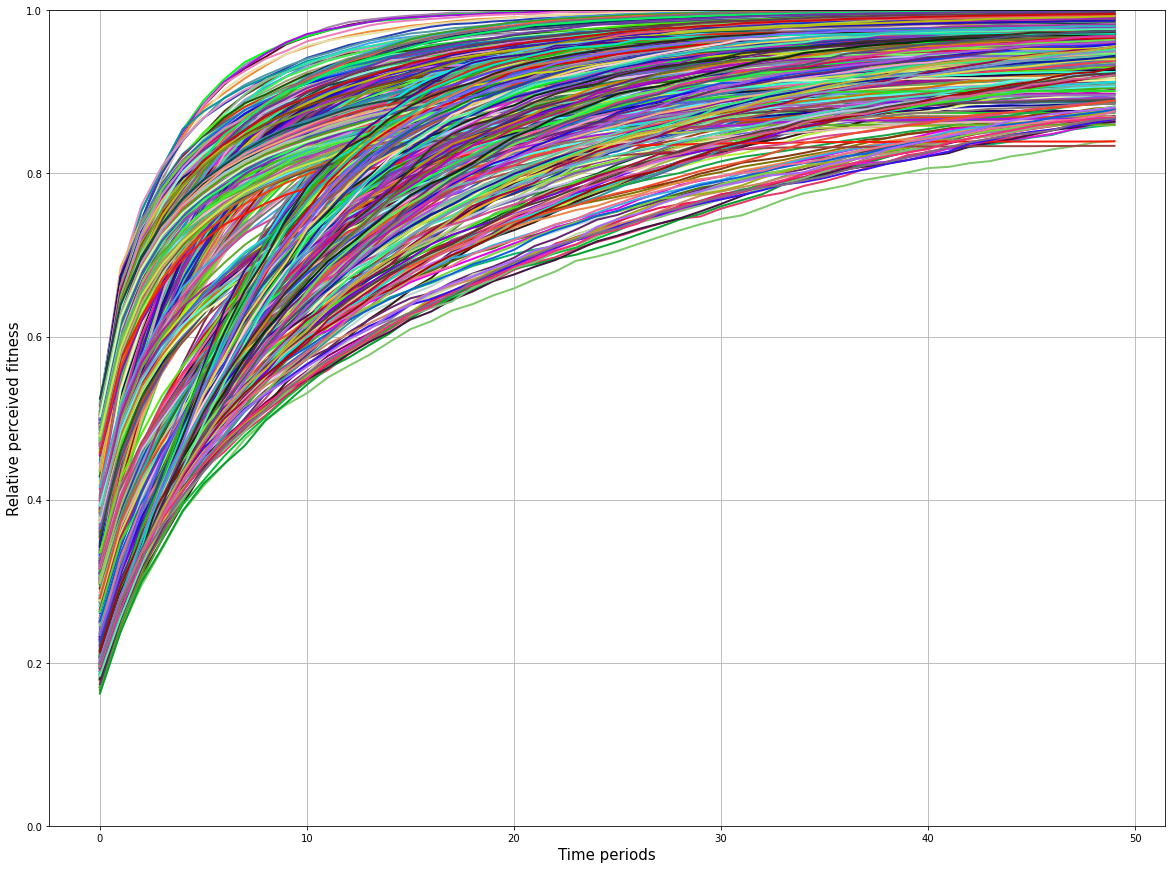

<Figure size 432x288 with 0 Axes>

In [369]:
plot_results(results)

In [370]:
print("Done")

Done


In [371]:
results[0]

{'name': 'N = 4, K = 0, C = 0, p_jump = 0',
 'N': 4,
 'K': 0,
 'C': 0,
 'p_jump': 0,
 'avg_n_peaks': 1.0,
 'max_n_peaks': 1.0,
 'min_n_peaks': 1.0,
 'avg_value': 0.502540970505952,
 'max_value': 0.9516741855017374,
 'min_value': 0.0543913158209155,
 'fitness': array([0.50321622, 0.6265171 , 0.72354034, 0.79532212, 0.8465724 ,
        0.88283231, 0.90902069, 0.92898675, 0.94294045, 0.95841028,
        0.96782236, 0.97524418, 0.98209142, 0.98643847, 0.98916543,
        0.99210268, 0.99459898, 0.99520209, 0.99675151, 0.99755476,
        0.99755476, 0.99772153, 0.99810396, 0.99898956, 0.99898956,
        0.99910176, 0.99910176, 0.99910176, 0.99910176, 0.99968002,
        0.99968002, 0.99968002, 0.99968002, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ])}

## Export for Interactive Web App

In [377]:
def tansform_to_chartjs(results):
    export = {}
    for i,res in enumerate(results):
        res["name"]= generate_title(res["N"], res["K"], res["C"], res["p_jump"])
        export[res["name"]] = {
            "label":res["name"],
            "data":list(np.around(res["fitness"],decimals=3)),
            "borderColor": "#"+ ("%06x" % random.randrange(0, 16**6)),
            "backgroundColor": "rgba(0, 0, 0, 0)",
        }
        
    with open('chartjs.json', 'w') as outfile:
        json.dump(export, outfile)    
    
    

In [378]:
tansform_to_chartjs(results)

## Statistics for Landscapes

In [374]:
def generate_relative_fitness_data(N=6, K=4):
    Cs = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    relative_fitness_data = []
    for C in Cs:
        result = run_simulation(N=N, K=K, C=C, p_jump=0)
        relative_fitness_data.append(result)
                
    return relative_fitness_data

In [375]:
df_N6_K4 = pd.DataFrame(generate_relative_fitness_data(N=6, K=4))
df_N6_K0 = pd.DataFrame(generate_relative_fitness_data(N=6, K=0))

Run simulation with N = 6, K = 4, C = 0, p_jump = 0
Summary statistics
N = 6, K = 4, C = 0, p_jump = 0
average number of peaks: 6.947
maximum number of peaks: 12.0
minimum number of peaks: 3.0
average average value: 0.4996228777119803
average maximum value: 0.911437789738943
average minimum value: 0.08854050315797869
#######################################################
Run simulation with N = 6, K = 4, C = 0.1, p_jump = 0
Summary statistics
N = 6, K = 4, C = 0.1, p_jump = 0
average number of peaks: 6.395
maximum number of peaks: 11.0
minimum number of peaks: 2.0
average average value: 0.6299913228327666
average maximum value: 1.2089471811194115
average minimum value: 0.1882947737010481
#######################################################
Run simulation with N = 6, K = 4, C = 0.2, p_jump = 0
Summary statistics
N = 6, K = 4, C = 0.2, p_jump = 0
average number of peaks: 4.868
maximum number of peaks: 9.0
minimum number of peaks: 2.0
average average value: 0.7587245836654615
average 

In [376]:
df_N6_K0

,name,N,K,C,p_jump,fitness,avg_n_peaks,max_n_peaks,min_n_peaks,avg_value,max_value,min_value
0,"N = 6, K = 0, C = 0, p_jump = 0",6,0,0.0,0,"[0.5008682321987441, 0.5851485578213219, 0.659...",1.000,1.0,1.0,0.502976,0.936414,0.071902
1,"N = 6, K = 0, C = 0.1, p_jump = 0",6,0,0.1,0,"[0.37943446652209556, 0.45515577239319804, 0.5...",2.211,4.0,1.0,0.628522,1.164234,0.161028
2,"N = 6, K = 0, C = 0.2, p_jump = 0",6,0,0.2,0,"[0.29900373796471225, 0.37007291430318684, 0.4...",2.033,3.0,2.0,0.758358,1.569777,0.291089
3,"N = 6, K = 0, C = 0.3, p_jump = 0",6,0,0.3,0,"[0.24687186836815117, 0.32121714476339014, 0.3...",2.005,3.0,2.0,0.887255,1.919885,0.373592
4,"N = 6, K = 0, C = 0.4, p_jump = 0",6,0,0.4,0,"[0.22629436214960585, 0.29784655752329237, 0.3...",2.000,2.0,2.0,1.016865,2.219264,0.501530
5,"N = 6, K = 0, C = 0.5, p_jump = 0",6,0,0.5,0,"[0.21230468350635903, 0.2876145319058281, 0.35...",2.000,2.0,2.0,1.151404,2.540393,0.588813
6,"N = 6, K = 0, C = 0.6, p_jump = 0",6,0,0.6,0,"[0.20651575839229658, 0.28287923121686037, 0.3...",2.000,2.0,2.0,1.277603,2.917028,0.701060
7,"N = 6, K = 0, C = 0.7, p_jump = 0",6,0,0.7,0,"[0.18386084745420175, 0.2559275294524574, 0.33...",2.000,2.0,2.0,1.408424,3.250935,0.774685
8,"N = 6, K = 0, C = 0.8, p_jump = 0",6,0,0.8,0,"[0.17657212906944386, 0.2557576786624021, 0.34...",2.000,2.0,2.0,1.537464,3.586183,0.857862
9,"N = 6, K = 0, C = 0.9, p_jump = 0",6,0,0.9,0,"[0.17345041516551055, 0.2533707240807053, 0.33...",2.000,2.0,2.0,1.668522,3.896444,1.016880


In [352]:
def plot_relative_fitness_statistics(dfs, names):
    """
    plots the results over a time period
    """
    plt.figure(1, facecolor='white', figsize=(20, 15))
    
    for i, df in enumerate(dfs):
        
        x = list(df.C)
        max_value = list(df.max_value)
        min_value = list(df.min_value)  
        avg_value = list(df.avg_value)
   

        plt.fill_between(x, max_value, min_value, color=colors[i], alpha=0.3)
        plt.plot(x, avg_value, 
                     color=colors[i], 
                     linewidth=2,
                     label=names[i],
                     marker=markers[i]
                    )
        
    plt.grid(True)        
    plt.ylim(0, 4)
    plt.legend(loc=4,prop={'size':15})
    # plt.title('Min, Max and Average absolute perceived fitness for different values of C', size=15)
    plt.xlabel('C', size=15)
    plt.ylabel('Absolute perceived fitness', size=15)
    plt.show()
    plt.clf()

In [353]:
def plot_peaks_statistics(dfs, names):
    """
    plots the peaks over differnt Cs
    """
    plt.figure(1, facecolor='white', figsize=(20, 15))

    
    for i, df in enumerate(dfs):
        
        x = list(df.C)
        avg_n_peaks = list(df.avg_n_peaks)
        max_n_peaks = list(df.max_n_peaks)
        min_n_peaks = list(df.min_n_peaks)   
   
        plt.plot(x, avg_n_peaks, 
                     color=colors[i], 
                     linewidth=2,
                     label=names[i],
                     marker=markers[i]
                    )
        plt.fill_between(x, max_n_peaks, min_n_peaks, color=colors[i], alpha=0.3)  
            
    
    plt.grid(True)
    plt.ylim(0, 16)
    plt.legend(loc=4,prop={'size':15})
    # plt.title('Min, Max and Average amount of peaks for different values of C', size=15)
    plt.xlabel('C', size=15)
    plt.ylabel('Amount of global peaks', size=15)
    plt.show()
    plt.clf()

In [354]:
colors = ['r','g','b','c','m','k','tab:purple','tab:olive']
markers = ['d','x','+','H','o','s','|','_']
names = [
    "N = 6, K = 0",
    "N = 6, K = 4",

]
dfs = [
    df_N6_K0,
    df_N6_K4,
]

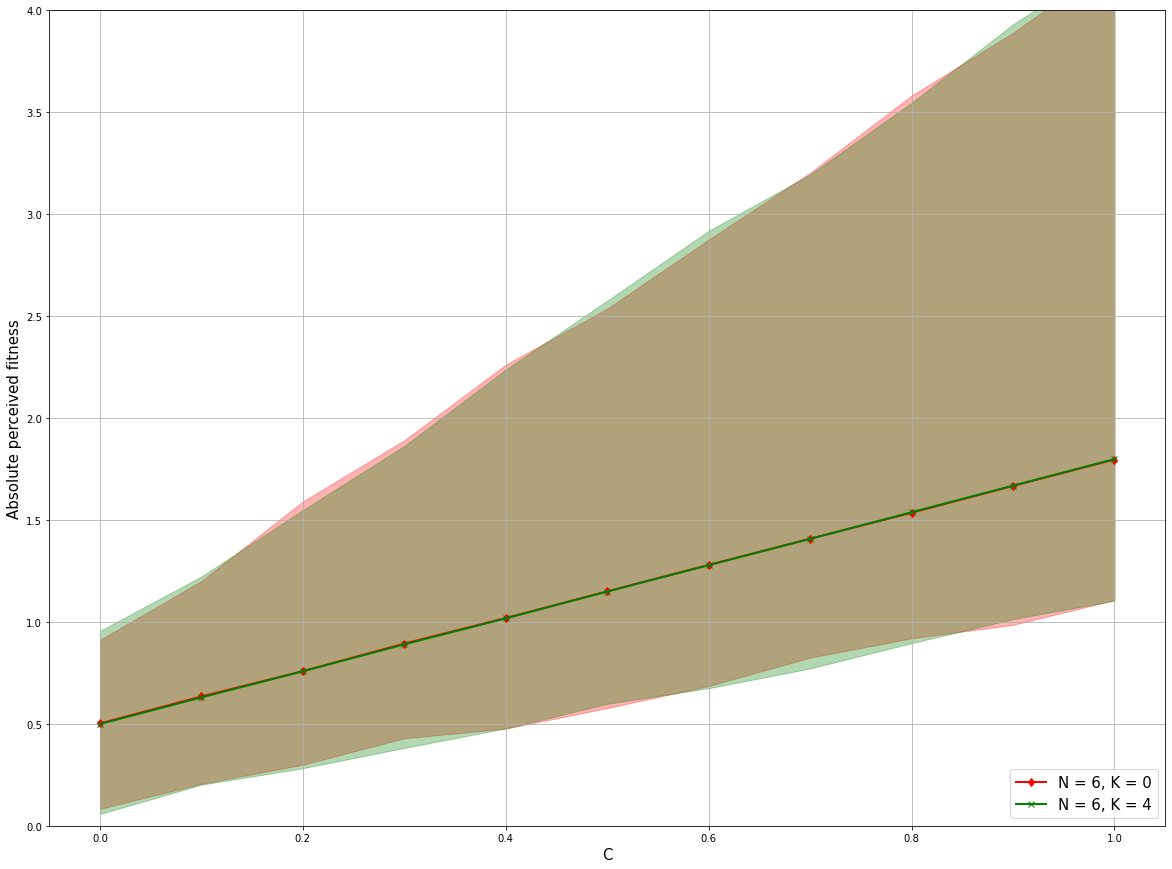

<Figure size 432x288 with 0 Axes>

In [355]:
plot_relative_fitness_statistics(dfs, names)

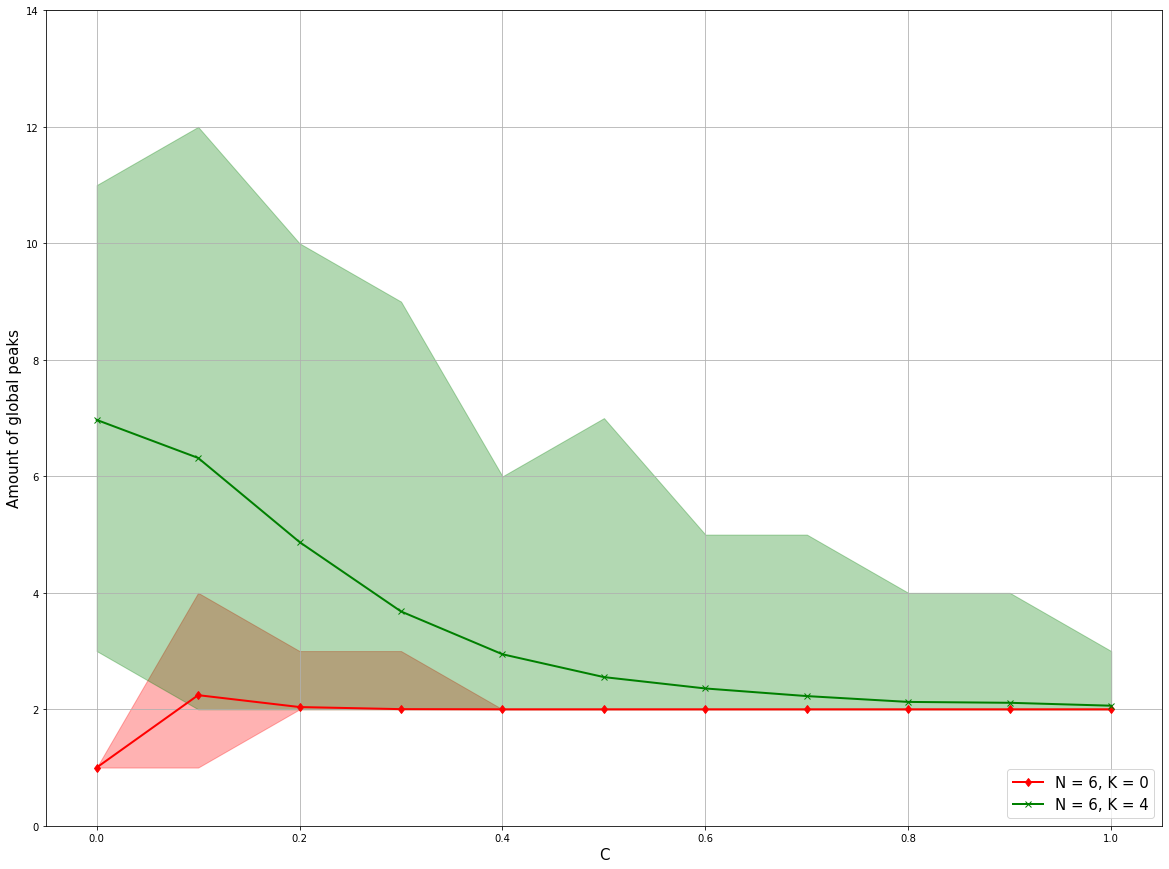

<Figure size 432x288 with 0 Axes>

In [356]:
plot_peaks_statistics(dfs, names)